
Query the HYDAT database for runoff events in BC and Alberta that fall within 175km of a radar station in Western Canada.  

Filter for watersheds with data after June 2007.  

Filter for watersheds larger than 15 km^2 and smaller than 500 km^2.

Output table like:

| Station | ID | Drainage Area [$km^2$] | Start Date | End Date |
|---|---|---|---|---|
| Elaho | EHBN008 | 400 | 2007 | 2017 |


In [1]:
import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona
from geopy import distance

from numba import jit

from shapely.geometry import shape, mapping

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3
from bokeh.layouts import gridplot

from radar_scrape import get_radar_img_urls, request_img_files
from get_station_data import get_daily_runoff
output_notebook()

Loading BokehJS ...

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
IMG_DIR = os.path.join(PROJECT_DIR, 'data/radar_img')
RADAR_IMG_DIR = os.path.join(PROJECT_DIR, 'data/sorted_radar_images')

In [3]:
stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
stations_df['RADAR_Overlap'] = stations_df['Year To'].astype(int) - 2007

In [4]:
print(stations_df.columns)

Index(['Station Number', 'Station Name', 'Province', 'Status', 'Latitude',
       'Longitude', 'Year From', 'Year To', 'Gross Drainage Area (km2)',
       'Effective Drainage Area (km2)', 'Regulation', 'Data Type',
       'Operation Schedule', 'Sediment', 'RHBN', 'Real-Time', 'Datum Name',
       'Publishing Office', 'Operating Agency', 'Contributed', 'Elevation',
       'RADAR_Overlap'],
      dtype='object')


In [5]:
stations_filtered = stations_df[stations_df['RADAR_Overlap'] > 0]

In [6]:
stations_filtered = stations_filtered[stations_filtered['Regulation'] == 'N']

In [7]:
stations_filtered.rename(columns={'Gross Drainage Area (km2)': 'DA'}, inplace=True)
stations_filtered = stations_filtered[(stations_filtered['Province'] == 'BC') | (stations_filtered['Province'] == 'AB')]

In [8]:
# define radar sites
radar_sites = {'CASAG': {'lat_lon': [49.0580516, -122.470667], # radar location code, lat/lon
                       'scale': 1,
                      'alt_name': 'Aldergrove',
                        }, # km/pixel                       
               'CASPG': {'lat_lon': [53.916943, -122.749443], # radar location code, lat/lon
                       'scale': 1,
                      'alt_name': 'Prince George',}, # km/pixel}, # km/pixel
               'CASSS': {'lat_lon': [50.271790, -119.276505], # radar location code, lat/lon
                       'scale': 1,
                      'alt_name': 'Silver Star',}, # km/pixel}, # km/pixel
               'CASSI': {'lat_lon': [48.407326, -123.329773], # radar location code, lat/lon
                       'scale': 1,
                      'alt_name': 'Victoria',}, # km/pixel}, # km/pixel
               'CASSM': {'lat_lon': [51.206092, -113.399426],
                        'scale': 1,
                        'alt_name': 'Strathmore'},
              }

def find_closest_radar_stn(row):
    """
    To retrieve radar images, we need to find the closest radar location
    to the station of interest.  
    Input the station number,
    returns the location code of the nearest radar station.
    """
    stn_data = row['Station Number']
    
    s1 = (row['Latitude'], row['Longitude'])
    min_dist = 1E6
    closest_stn = None
    for site in radar_sites.keys():

        s2 = [*radar_sites[site]['lat_lon']]        

        this_dist = distance.distance(s2, s1).km
    
        if this_dist < min_dist:
            min_dist = this_dist
            closest_stn = site
        
    return closest_stn

def calc_distance(row):
    wsc_stn_coords = (row['Latitude'], row['Longitude'])
    radar = row['Closest_radar']
    radar_coords = radar_sites[radar]['lat_lon']
    return distance.distance(radar_coords, wsc_stn_coords).km
    
    

In [9]:
# filter for stations within 200 km of the radar <sigh>
stations_filtered['Closest_radar'] = stations_filtered.apply(lambda row: find_closest_radar_stn(row), axis=1)
stations_filtered['Dist_to_radar'] = stations_filtered.apply(lambda row: calc_distance(row), axis=1)
# print(stations_filtered['Dist_to_radar'].head())
print(len(stations_filtered))


601


In [10]:
stations_filtered = stations_filtered[stations_filtered['Dist_to_radar'] < 175]
print(len(stations_filtered))

204


In [11]:
stn_df = stations_filtered[np.isfinite(stations_filtered['DA'].astype(float))]
stn_df = stn_df[stn_df['DA'].astype(float) >= 10]
stn_df = stn_df[stn_df['DA'].astype(float) < 1000].sort_values('DA')

In [12]:
df = stn_df[['Province', 'Station Number', 'Station Name', 'DA', 'Elevation', 'Latitude', 'Longitude', 'RADAR_Overlap']]
print('After filtering, there are {} candidate stations.'.format(len(stn_df)))

After filtering, there are 124 candidate stations.


In [468]:
st = 98
#71

test_stn = stn_df['Station Number'].iloc[st]
test_stn_info = stn_df[stn_df['Station Number'] == test_stn]

stn_da = stn_df['DA'].iloc[st]
stn_name = stn_df['Station Name'].iloc[st]
print('Station {} ({}) has a DA of {} km^2'.format(test_stn, stn_name, stn_da))

Station 05CC011 (WASKASOO CREEK AT RED DEER) has a DA of 487.0 km^2


In [469]:
df = get_daily_runoff(test_stn)
df['Year'] = df.index.year
df['Month'] = df.index.month

In [470]:
# filter by minimum radar date
df = df[df.index > pd.to_datetime('2007-05-31')]

In [471]:
df['Date'] = df.index.values

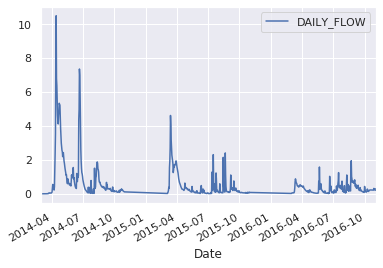

In [472]:
df[df['Year'] > 2013].plot('Date', 'DAILY_FLOW')

In [473]:
# from peak_detection import find_peaks

In [474]:
def find_peaks(data, lag=7, threshold=500, influence=0.5):
    # Settings (the ones below are examples: choose what is best for your data)
#     lag = 5         # lag 5 for the smoothing functions
#     threshold = 3.5  # 3.5 standard deviations for signal
#     influence = 0.5  # between 0 and 1, where 1 is normal influence, 0.5 is half
    # Initialize variables
    signals = np.zeros(len(data))            # Initialize signal results
    filteredY = np.empty(len(data))
    filteredY[:lag] = data[:lag]             # Initialize filtered series
    avgFilter = [0]                          # Initialize average filter
    stdFilter = [0]                          # Initialize std. filter
    avgFilter = {lag: np.mean(data[:lag])}      # Initialize first value
    stdFilter = {lag: np.std(data[:lag])}     # Initialize first value
    
    for i in range(lag + 1, len(data)):
        d = data[i]
        
        af = avgFilter[i-1]
        sf = stdFilter[i-1]
        
        if abs(d - af) > threshold * sf:
            if d > af:
                signals[i] = 1                     # Positive signal
            else:
                signals[i] = -1                    # Negative signal

            
            filteredY[i] = influence*d + (1-influence)*filteredY[i-1]
        else:
            signals[i] = 0                        # No signal
            filteredY[i] = 0
        
        
        # Adjust the filters
        avgFilter[i] = np.mean(filteredY[i-lag:i])
        stdFilter[i] = np.std(filteredY[i-lag:i])
        
    return signals, filteredY

n_test = 500

dats = list(df['DAILY_FLOW'].to_numpy())
sigs, f_dat = find_peaks(dats, influence=0.75, lag=7, threshold=5)

In [475]:
from bokeh.plotting import figure, output_file, show, output_notebook

input_sig = df[['DAILY_FLOW']].copy()
signal = np.array(sigs)
input_sig['sig'] = signal.copy().astype(int)
input_sig['f_sig'] = f_dat

foo = input_sig[input_sig['sig'] == 1].copy()
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime')
# add a circle renderer with a size, color, and alpha
p.circle(foo.index, foo['DAILY_FLOW'], size=10, color="red", 
         alpha=0.5, legend_label='{} pts'.format(len(foo)))
# p.line(input_sig.index, input_sig['f_sig'], color='blue')
p.line(input_sig.index, input_sig['DAILY_FLOW'], color='blue')
# p.line()
# show the results
show(p)

Find the summer baseflow

Break up the May to November records by periods where it comes back to within X% of baseflow.  

check durations of these periods, see how many there are.

In [476]:
# Based on code from Anomaly detection ML methods article:
# https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [477]:
lag_df = input_sig[['DAILY_FLOW']].copy()
lag_df.rename(columns={'DAILY_FLOW': 'Q'}, inplace=True)

num_lags = int(np.ceil(stn_da / 100 + 7))


for i in range(1,num_lags):
    lag_df['Q{}'.format(i)] = lag_df['Q'].shift(i)

lag_df.dropna(inplace=True)


In [478]:
# # add check for baseflow, and extend/trim the target record start and end to isolate the low flow 
# summer period
# def extract_summer_data(data):
#     summer_months = [8, 9, 10]
#     return data[data.index.month.isin(summer_months)]

def split_train_and_test_data(data, summer_months, training_year):
    all_years = list(set(data.index.year))
    all_years_data = data[['Q']].groupby(data.index.year).mean()
    all_year_means = list(all_years_data.to_numpy().flatten())
    if len(all_years) % 2 == 0:
        all_year_means.append(0)

    median_year_flow = np.median(all_year_means)
    median_year = all_years_data[all_years_data['Q'] == median_year_flow].index.values[0]
    train_data = data[data.index.year == training_year]#median_year]

    train_data = train_data[train_data.index.month.isin(summer_months)]
    test_data = data
    return train_data, test_data

In [479]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [480]:
from sklearn.decomposition import PCA

def do_PCA(X_train, X_test):
    
    for n_components in range(2, 6):

        pca = PCA(n_components=n_components, svd_solver= 'full')
        X_train_PCA = pca.fit_transform(X_train)
        X_train_PCA = pd.DataFrame(X_train_PCA)
        X_train_PCA.index = X_train.index

        X_test_PCA = pca.transform(X_test)
        X_test_PCA = pd.DataFrame(X_test_PCA)
        X_test_PCA.index = X_test.index

        var_expl = 100*np.sum(pca.explained_variance_ratio_)
        if var_expl >= 90:
            return X_train_PCA, X_test_PCA, var_expl, n_components
    return X_train_PCA, X_test_PCA, var_expl, n_components


def train_model(lag_df, summer_months, training_year):

    dataset_train, dataset_test = split_train_and_test_data(lag_df, summer_months, training_year)
    
    if len(dataset_train) < 2:
        return pd.DataFrame([]), 'No training data for selected parameters.'

    scaler = preprocessing.MinMaxScaler()

    X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                                  columns=dataset_train.columns, 
                                  index=dataset_train.index)
    # Random shuffle training data
    X_train.sample(frac=1)

    X_test = pd.DataFrame(scaler.transform(dataset_test), 
                                 columns=dataset_test.columns, 
                                 index=dataset_test.index)
    
    X_train_PCA, X_test_PCA, var_expl, n_components = do_PCA(X_train, X_test)
    
    data_train = np.array(X_train_PCA.values)
    data_test = np.array(X_test_PCA.values)
    
    def cov_matrix(data, verbose=False):
        covariance_matrix = np.cov(data, rowvar=False)
        if is_pos_def(covariance_matrix):
            inv_covariance_matrix = np.linalg.inv(covariance_matrix)
            if is_pos_def(inv_covariance_matrix):
                return covariance_matrix, inv_covariance_matrix
            else:
                print("Error: Inverse of Covariance Matrix is not positive definite!")
        else:
            print("Error: Covariance Matrix is not positive definite!")

    cov_matrix, inv_cov_matrix = cov_matrix(data_train)

    mean_distr = data_train.mean(axis=0)

    dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
    dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
    threshold = MD_threshold(dist_train, extreme = True)
    
    anomaly_train = pd.DataFrame()
    anomaly_train['Mob dist']= dist_train
    anomaly_train['Thresh'] = threshold
    # If Mob dist above threshold: Flag as anomaly
    anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
    anomaly_train.index = X_train_PCA.index
    anomaly = pd.DataFrame()
    anomaly['Mob dist']= dist_test
    anomaly['Thresh'] = threshold
    # If Mob dist above threshold: Flag as anomaly
    anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
    anomaly.index = X_test_PCA.index
    anomaly.head()
    
    anomaly_alldata = pd.concat([anomaly_train, anomaly])
    
    event_times = np.where(anomaly_alldata['Anomaly'].values[:-1] != anomaly_alldata['Anomaly'].values[1:])[0]
    events = pd.merge(input_sig, anomaly_alldata.iloc[event_times,:], how='inner', 
                      left_index=True, right_index=True)

    events = events.loc[~events.index.duplicated(keep='first')]

    # print(events.head(50))
    
    if len(events) == 0:
        return pd.DataFrame([]), 'No events found.'
    elif events.iloc[0]['Anomaly'] == True:
        events = events.iloc[1:]
        
    # create a column of time difference between events in days
    events['dt_days'] = events.index.to_series().diff(1)
    

    a = time.time()

    last_event_end = False

    new_events = pd.DataFrame()

    # iterate through the detected event pairs 
    for i in np.arange(0, len(events) - 1, 2):
        # parse a single event pair
        this_event = events.iloc[i:i+2]

        check_sign_switch = this_event['Anomaly'].values[0] != this_event['Anomaly'].values[1]
        concurrent_wsc = lag_df[(lag_df.index >= this_event.index.values[0]) & (lag_df.index <= this_event.index.values[1])][['Q']]
        peak_in_middle = check_peak_in_middle(this_event, concurrent_wsc)

        if (check_sign_switch) & (peak_in_middle):

            # get the start date
            this_event_start = pd.to_datetime(this_event[this_event['Anomaly'] == False].index.values[0])
            # get the end date
            this_event_end = pd.to_datetime(this_event[this_event['Anomaly'] == True].index.values[0])

            new_event_start = lag_df[lag_df.index == this_event_start][['Q']]
            new_event_end = lag_df[lag_df.index == this_event_end][['Q']]

            adjusted_start_date = pd.to_datetime(adjust_edge_date(this_event_start, lag_df[['Q']], 'start'))

            new_event_start = lag_df[lag_df.index == adjusted_start_date][['Q']]

            if last_event_end is not False:

                # find if the start date is on the rising limb - adjust if so
                if adjusted_start_date < last_event_end:
                    new_event_start = lag_df[lag_df.index == this_event_start][['Q']]



            new_event_start['timing'] = 'start'
            new_event_end['timing'] = 'end'

            min_time_check = (new_event_end.index - new_event_start.index).days > 1
            max_time_check = (new_event_end.index - new_event_start.index).days <= 14
            start_month = new_event_start.index.month
            end_month = new_event_end.index.month
            season_check = (start_month > 5) & (start_month <= 11) & (end_month <= 11)

            if (min_time_check) & (max_time_check) & (season_check):
                # filter out events that are longer than 5 days
                new_events = new_events.append(new_event_start)
                new_events = new_events.append(new_event_end)

            last_event_end = pd.to_datetime(this_event_end)


    b = time.time()

    new_events.sort_index(inplace=True)

    new_events['dt_days'] = new_events.index.to_series().diff(1)
    # new_events['Datetime'] = pd.to_datetime(new_events.index.values)
    msg = '{} components explain {:.1f}% of the variance and find {} events in {:.2f}'.format(n_components, var_expl,  
                                                                                             len(new_events), b-a, )
    
    return new_events, msg


In [481]:
def adjust_edge_date(initial_date, data, direction):
    """
    If the start flow is on a rising limb, adjust the start to the start of the runoff event.
    """
    initial_val = data[data.index == initial_date]['Q']

    if direction == 'end':
        search_criteria = (data.index <= initial_date + pd.Timedelta('7 days')) & (data.index >= initial_date)
        search_direction = -1
    elif direction == 'start':
        search_criteria = (data.index >= initial_date - pd.Timedelta('7 days')) & (data.index <= initial_date)
        search_direction = 1
        
        
    extended_week_vals = data[search_criteria][['Q']]
    extended_week_vals['diff'] = extended_week_vals.diff(periods=search_direction)
    extended_week_vals['pct_change'] = 100 * extended_week_vals['diff'] / extended_week_vals['Q']

    if direction == 'start':
        try:
            extended_week_vals.at[extended_week_vals.index.min(),'diff'] = -1
            change_point_row = extended_week_vals[['pct_change']].idxmax()
            if len(change_point_row) > 1:
                change_point_date = extended_week_vals.loc[change_point_row - pd.DateOffset(1)].index.values[0]
                adjusted_date = change_point_date
            else:
                adjusted_date = initial_date
            
        except ValueError as err:
#                 print(err)
#                 print('no change')
            adjusted_date = initial_date

    elif direction == 'end':
#             adjusted_dates.append(s)
        try:
            change_point = extended_week_vals[extended_week_vals['diff'] < 0][['Q']].idxmin().values[0]
            adjusted_dates = change_point
#                 print(s, change_point)

        except ValueError as err:
#                 print(extended_week_vals['Q'].min())
            change_point = extended_week_vals[extended_week_vals['Q'] == extended_week_vals['Q'].min()].index.values[0]
#                 print(err)
#                 print('no change')
            adjusted_date = change_point

            
    return pd.to_datetime(adjusted_date)

def check_peak_in_middle(event, data):
    """
    Ensure there is a peak between the start and end points
    so we aren't targeting a non-runoff event.
    """
    start_time = event.index.values[0] 
    end_time = event.index.values[-1]
    max_time = data[data['Q'] == data['Q'].max()].index.values[0]
    if (max_time == start_time) | (max_time == end_time):
        return False
    else:
        return True

In [482]:
import itertools
def get_combinations(months, n):
    combinations = []
    for comb in itertools.combinations(months, n):
        combinations.append(comb)
    return combinations

In [483]:
training_months = [6, 7, 8, 9, 10, 11, 12]
training_year = list(set([e.year for e in lag_df.index]))

all_combinations = np.array([get_combinations(training_months, n) for n in range(1,len(training_months))]).flatten()

flat_list = [item for sublist in all_combinations for item in sublist]

best_radar_stn = test_stn_info['Closest_radar'].values[0]

max_events = 0
best_events = None
trial_data = []
for y in training_year:
    for c in flat_list:
        new_events, msg = train_model(lag_df, c, y)
        if len(new_events) == 0:
            trial_data.append([y, c, 0])
        else:
            trial_data.append([y, c, len(new_events)])
        if len(new_events) > 0:
            if len(new_events) > max_events:
                max_events = len(new_events)
                best_events = new_events
                print(msg)
            

5 components explain 67.0% of the variance and find 26 events in 0.37
3 components explain 90.9% of the variance and find 38 events in 0.50
3 components explain 90.6% of the variance and find 40 events in 0.58
3 components explain 92.3% of the variance and find 72 events in 0.84


In [484]:
# save the best_events dataframe as a csv
events_save_path = os.path.join(PROJECT_DIR, 'data/precip_events_data/{}_events.csv'.format(test_stn))
best_events['radar_stn'] = best_radar_stn
best_events.to_csv(events_save_path)

# save the trial information to investigate the solution space and optimization exercise
trials_save_path = os.path.join(PROJECT_DIR, 'data/precip_events_data/{}_trials.csv'.format(test_stn))
trial_df = pd.DataFrame(trial_data, columns=['train_year', 'train_months', 'num_results'])
trial_df.to_csv(trials_save_path)

In [485]:
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime')

e1 = best_events[best_events['timing'] == 'start']
e2 = best_events[best_events['timing'] == 'end']

p.circle(e1.index, e1['Q'], color='red', alpha=0.5, size=10, legend_label='start')
p.circle(e2.index, e2['Q'], color='blue', alpha=0.5, size=10, legend_label='end')

# p.line(input_sig.index, input_sig['f_sig'], color='blue')
p.line(input_sig.index, input_sig['DAILY_FLOW'], color='blue')
# p.line()
# show the results
show(p)

In [491]:
# create grid plot of individual events

plots = []

for i in np.arange(0, len(best_events) - 1, 2):
    
    # parse a single event pair
    this_event = best_events.iloc[i:i+2]
    
    s1 = figure(background_fill_color="#fafafa", x_axis_type='datetime')
    
    s1.circle(this_event.index, this_event['Q'], 
              size=12, alpha=0.8, color="red")#, legend_label='{estimated endpoints}')
    s1.xaxis.major_label_orientation = math.pi/2
    this_start = pd.to_datetime(this_event.index.values[0])
    this_end = pd.to_datetime(this_event.index.values[1])
    this_dat = lag_df[(lag_df.index >= this_start) & (lag_df.index <= this_end)][['Q']]
    
    if (this_end.month < 12) & (this_start.month > 5):
        year = this_event.index.year.values[0]
        month = this_event.index.month.values[0]
        day = this_event.index.day.values[0]
        date = '{}-{}-{}'.format(year, month, day)
        s1.line(this_dat.index, this_dat['Q'], color='blue')
        plots.append(s1)

print('there are {} plots'.format(len(plots)))

there are 36 plots


In [492]:
# if len(plots) < 6:
#     grid = gridplot(plots, plot_width=150, plot_height=150)
# else:
n_cols = 5
n_rows = int(np.ceil(len(plots) / n_cols))


g = []
for i in range(0, len(plots), n_cols):
    g += [plots[i:i+n_cols]]
grid = gridplot(g, plot_width=150, plot_height=150)

In [493]:
show(grid)

In [494]:
event_pairs = []
for i in np.arange(0, len(best_events) - 1, 2):
    # parse a single event pair
    this_event = best_events.iloc[i:i+2]
    date_pair = [e.astype(str).replace('T', ' ').split('.')[0].split(' ')[0] for e in this_event.index.values]
    this_start = pd.to_datetime(this_event.index.values[0])
    this_month = this_start.month
    if (this_month > 5) & (this_month <= 11) & (this_start > pd.to_datetime('2007-01-01')):
        event_pairs.append(date_pair)

In [495]:
print('Stn {}: {}'.format(test_stn, test_stn_info['Station Name'].values[0]))
print('There are {} events that meet the criteria.'.format(len(event_pairs)))

Stn 05CC011: WASKASOO CREEK AT RED DEER
There are 36 events that meet the criteria.


### Load Radar, Mask with Catchment, and Clip all Retrieved Images

First, make sure basin geometry is available before requesting all images.

In [496]:
def get_polygon(stn):
    gdb_path = os.path.join(DB_DIR, 'WSC_Basins.gdb.zip')
    data = gpd.read_file(gdb_path, driver='FileGDB', layer='EC_{}_1'.format(stn))
    return data.geometry

def find_closest_radar_stn(wsc_stn):
    """
    To retrieve radar images, we need to find the closest radar location
    to the station of interest.  
    Input the station number,
    returns the location code of the nearest radar station.
    """
    stn_data = stn_df[stn_df['Station Number'] == wsc_stn]
    s1 = [stn_data['Latitude'].values[0], stn_data['Longitude'].values[0]]
    min_dist = 1E6
    closest_stn = None
    for site in radar_sites.keys():
        s2 = [*radar_sites[site]['lat_lon']]
        this_dist = np.sqrt((s2[0] - s1[0])**2 + (s2[1] - s1[1])**2)

        if this_dist < min_dist:
            min_dist = this_dist
            closest_stn = site
        
    return closest_stn

basin_geom = get_polygon(test_stn)
basin_geom = basin_geom.to_crs('EPSG:4326')
basin_bbox = basin_geom.bounds
print(basin_bbox)

         minx       miny        maxx       maxy
0 -113.982029  51.972492 -113.601088  52.281161


In [497]:
all_img_urls = get_radar_img_urls(event_pairs, best_radar_stn)
print('There are {} image files to query.'.format(len(all_img_urls)))

There are 0 image files to query.


# TODO:



## Further Work

Find all the stations that have radar overlap.  

Find a bunch of concurrent runoff events, and estimate the error based on the overlapping radar info.

In [498]:
time0 = time.time()
request_img_files(all_img_urls, test_stn, best_radar_stn)
time1 = time.time()

For 05CC011 there are 0 images to be requested from the CASSM radar station.


In [499]:
print('Time to check {} image links = {:.0f}s ({:.2f}s/image)'.format(len(all_img_urls), 
                                                                      (time1 - time0), 
                                                                      (time1 - time0)/len(all_img_urls)))

ZeroDivisionError: float division by zero

In [500]:
from shapely.geometry import Polygon

def get_ubc_polygon():
    points = [-123.1876189229259,49.27349631820059, -123.2168376964195,49.27886813665509,
              -123.250951627253,49.28123248845857, -123.2686880871375,49.26628206996413, 
              -123.2577985144227,49.25107796072373, -123.2296736741512,49.23345938143058, 
              -123.2086850019333,49.22474925352834, -123.1911799345363,49.22020024319045, 
              -123.1852881427934,49.2196036807795, -123.1876189229259,49.27349631820059, ]
    lat_list = []
    lon_list = []
    for i in range(0, len(points), 2):
        lat_list.append(points[i])
        lon_list.append(points[i + 1])
#     gdb_path = os.path.join(PROJECT_DIR, path)
#     data = gpd.read_file(gdb_path, driver='kmz')
#     return data.geometry
    minx = min(lat_list)
    maxx = max(lat_list)
    miny = min(lon_list)
    maxy = max(lon_list)
    bbox = pd.DataFrame({'minx': [minx], 'miny': [miny],
                        'maxx': [maxx], 'maxy': [maxy]})
    return Polygon(zip(lat_list, lon_list)), bbox

In [501]:
def get_pixel_coordinates(closest_stn):
    img_coord_path = 'data/radar_img_pixel_coords'
    img_coord_file = [f for f in os.listdir(img_coord_path) if closest_stn in f][0]
    return pd.read_json(os.path.join(img_coord_path, img_coord_file))


def get_img_mask(closest_stn, basin_geom):
    c_df = get_pixel_coordinates(closest_stn).to_numpy().flatten()
    all_points = [tuple(e) for e in c_df]
    list_pts_df = pd.DataFrame()
    list_pts_df['Lat'] = [e[1] for e in all_points]
    list_pts_df['Lon'] = [e[0] for e in all_points]
#     print(list_pts_df)
    gdf = gpd.GeoDataFrame(list_pts_df, geometry=gpd.points_from_xy(list_pts_df.Lat, list_pts_df.Lon))
    
    points = gdf['geometry'].values
    mask = np.zeros(len(points))
    for i, pt in enumerate(points):
        point = shape(pt)
        if point.within(shape(basin_geom[0])):
            mask[i] = 1
    return mask.reshape(480,480)


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[ymin:ymax+1, xmin:xmax+1]


@jit
def mask_image(img_array, mask):
    mask_idx = np.where(mask==0)
    rows = mask_idx[0]
    cols = mask_idx[1]
    filtered_img = np.zeros((480, 480, 3))
    for n in range(480):
        for m in range(480):
            if mask[n, m] == 0:
                filtered_img[n, m] = 0
            else:
                filtered_img[n, m] = img_array[n, m]
    return filtered_img

In [502]:
def mask_images_and_save(gif_images, mask, test_stn, best_radar_stn):
    origin_path = os.path.join(RADAR_IMG_DIR, best_radar_stn)
    save_path = os.path.join(PROJECT_DIR, 'data/masked_img/{}'.format(test_stn))
    for t_img in gif_images:
        new_filename = t_img.split('.')[0] + '_crp.gif'
        time0 = time.time()      
        origin_full_path = os.path.join(origin_path, t_img)
        new_file_path = os.path.join(save_path, new_filename)
#         if os.path.exists(origin_full_path):
#             print('hiiii')
        if os.path.getsize(origin_full_path) > 100:
            gif_img = Image.open(origin_full_path).convert('RGB')
            img_array = np.asarray(gif_img)[:,:480].astype(np.uint8)        
            filtered_img = mask_image(img_array, mask)
            time1 = time.time()
            cropped_array = bbox2(filtered_img)
            cropped_img = Image.fromarray(cropped_array.astype(np.uint8))
            cropped_img.save(os.path.join(save_path, new_filename))


def get_event_times(df):
    event_pairs = []
    for i in np.arange(0, len(df) - 1, 2):    
        # parse a single event pair
        this_event = df.iloc[i:i+2]
        date_pair = [e.astype(str).replace('T', ' ').split('.')[0].split(' ')[0] for e in this_event.index.values]
        this_start = pd.to_datetime(this_event.index.values[0])
        this_month = this_start.month
        if (this_month > 5) & (this_month <= 11) & (this_start > pd.to_datetime('2007-01-01')):
            event_pairs.append(date_pair)
    return event_pairs
    
def get_events_df_from_file(stn):
    event_csv_path = os.path.join(PROJECT_DIR, 'data/precip_events_data/{}.csv'.format(stn))
    event_df = pd.read_csv(event_csv_path, parse_dates=True, index_col='DATE')
    return event_df

def get_possible_filenames_from_event_time(event_pair):
    filenames = []
    for p in event_pair:
        start, end = p[0], p[1]
        datetime_range = [str(pd.to_datetime(e).strftime('%Y%m%d%H%M')) + '.gif' for e in pd.date_range(pd.to_datetime(start), 
                                       pd.to_datetime(end),
                                      freq='1H').values]
        filenames += datetime_range
    return set(filenames)

def get_radar_images_for_events(wsc_stn, radar_stn):
    event_df = get_events_df_from_file(wsc_stn)
    event_pairs = get_event_times(event_df)
    
    files_to_search = get_possible_filenames_from_event_time(event_pairs)
    
    existing_files = os.listdir(os.path.join(RADAR_IMG_DIR, radar_stn))
    
#     new_files = np.setdiff1d(files_to_search, existing_files)
    new_files = files_to_search.intersection(existing_files)
    return new_files

def get_gif_images(test_stn, closest_radar_stn):
    gif_path = 'data/sorted_radar_images/{}'.format(closest_radar_stn)
    save_path = 'data/masked_img/{}'.format(test_stn)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    return list(get_radar_images_for_events(test_stn, closest_radar_stn))

In [503]:
# ubc_polygon = get_ubc_polygon()

In [504]:
mask = get_img_mask(best_radar_stn, basin_geom)
# mask = get_img_mask('CASAG', ubc_polygon)

In [505]:
gif_images = get_gif_images(test_stn, best_radar_stn)
# gif_images = os.listdir(os.path.join(RADAR_IMG_DIR, 'CASAG'))

In [506]:
time0 = time.time()
mask_images_and_save(gif_images, mask, test_stn, best_radar_stn)
# mask_images_and_save(gif_images, mask, 'UBC', 'CASAG')
time1 = time.time()

print('Time to process {} images: {:.1f}s, ({:.2f}s/image)'.format(len(gif_images), 
                                                                   time1-time0, 
                                                                   (time1-time0)/len(gif_images)))

Time to process 4092 images: 29.2s, (0.01s/image)


In [ ]:
# open the image file

# gif_img = Image.open('data/radar_img/08HF006/200708261000.gif') # 640x480x3 array
# label = gif_img.convert('RGB')
# img_array = np.asarray(label)
# radar_img_array = np.asarray(img_array)[:,:480]
# color_bar_array = img_array[144:340, 515:535]
# color_bar_img = Image.fromarray(color_bar_array, mode='RGB')
# colors = color_bar_img.getcolors()

NameError: name 'gdf' is not defined

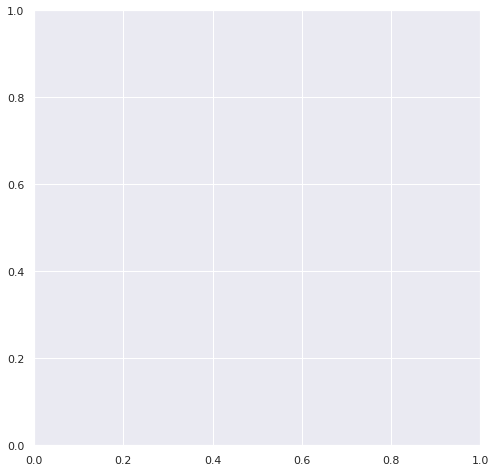

In [346]:
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot('geometry', ax=ax, color='lightgray', alpha=0.1)
basin_geom.plot(ax=ax, alpha=0.35, edgecolor='k', linewidth=2)
ax.plot(stn_lon, stn_lat, 'ro')
ax.grid(False)

In [ ]:
stn_lat = test_stn_info['Latitude'].values[0]
stn_lon = test_stn_info['Longitude'].values[0]

stn_coords = (stn_lon, stn_lat)

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(cropped_img)
plt.grid(None)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
# gdf.plot('geometry', ax=ax, color='lightgray', alpha=0.1)
basin_geom.plot(ax=ax, alpha=0.35, edgecolor='k', linewidth=2)

| Item | Default Unit | Other Possible Conversions |
|---|---|---|
| Station Loc. | Lat/Lon | UTM (with zone) | None |
| Catchment Boundary | ESRI:102001 | Anything Geopandas can do |
| Satellite Radar Img. | None | Radar centre can have UTM, pixels are 1kmx1km | 

In [ ]:
import matplotlib.pyplot as plt

# this is the right projection
z
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(stn_coords[0], stn_coords[1])
# gm.plot(ax=ax)
utm_coords.plot(ax=ax, alpha=0.1, edgecolor='k', linewidth=2)
ax.grid(False)
plt.show()

In [ ]:
# foo = utm_coords.to_crs("EPSG:32633")
t_wgs84 = utm_coords.to_crs('EPSG:3395') 
fig, ax = plt.subplots(figsize=(12,8))
t_wgs84.plot(ax=ax, alpha=0.5)
print(gm.crs)


## drop winter events and group for individual plotting

In [ ]:
def using_astype(start, end):
    s = start.strftime('%Y-%m-%d')
    print(s)
    print('%%%%%%')
    drg = pd.date_range('2000-07-31', '2015-08-05', freq='B')
    A = drg.values.astype('<M8[D]')
    B = end.asm8.astype('<M8[D]')
    return np.day_count(A, B)

In [ ]:
extracted_events = pd.concat([adj_starts, adj_ends], axis=0).sort_index()

filtered_events = []
for year in list(set(extracted_events.index.year)):
    target_months = [6, 7, 8, 9, 10]
    this_year_df = extracted_events[(extracted_events.index.year == year) & (extracted_events.index.month.isin(target_months))].copy()

    min_event = this_year_df[this_year_df.index == this_year_df.index.min()]['type'].values[0]

    # drop the first element if it's the end of an event
    if min_event == 'end':
#         print('dropped end at start of season')
        this_year_df.drop(index=this_year_df.index.min(), inplace=True)
        
    max_event = this_year_df[this_year_df.index == this_year_df.index.max()]['type'].values[0]

    # drop the first element if it's the end of an event
    if max_event == 'start':
#         print('dropped start at end of season')
        this_year_df.drop(index=this_year_df.index.max(), inplace=True)
        
    filtered_events.append(this_year_df)
#     print('')
#     print('')
#     print('There are {} events in {}'.format(len(this_year_df) / 2, year))
#     print(this_year_df)
    
    event_pairs = []
    start_dates = pd.to_datetime(this_year_df[this_year_df['type'] == 'start'].index.values)
    end_dates = pd.to_datetime(this_year_df[this_year_df['type'] == 'end'].index.values)
    
    for sd in start_dates:
        min_duration = 20
        min_end = None
        for ed in end_dates:
            if ((ed - sd).days < min_duration) & ((ed - sd).days > 0):
                min_duration = (ed - sd).days
                min_end = ed
                
        
                
        if (min_end is not None) & (min_duration < 20):
            event_pairs.append((sd, min_end))
                
                

    for pr in event_pairs:
        print(pr)
#         print(using_astype(d, end_dates))
    print('___')



In [ ]:
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime')

# p.circle(adj_starts.index, adj_starts['Q'], size=10, color="red", 
#          alpha=0.5, legend_label='start'.format(len(foo)))
# p.circle(adj_ends.index, adj_ends['Q'], size=10, color="blue", 
#          alpha=0.5, legend_label='end'.format(len(foo)))

p.circle(starts.index, starts['DAILY_FLOW'], size=10, color="red", 
         alpha=0.5, legend_label='start'.format(len(foo)))
p.circle(ends.index, ends['DAILY_FLOW'], size=10, color="blue", 
         alpha=0.5, legend_label='end'.format(len(foo)))
# p.line(input_sig.index, input_sig['f_sig'], color='blue')
p.line(input_sig.index, input_sig['DAILY_FLOW'], color='blue')
# p.line()
# show the results
show(p)

###  Autoencoder Neural Network

In [ ]:
seed(10)
tensorflow.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [ ]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 0)

In [ ]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

In [ ]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [ ]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [ ]:
scored[scored.index > pd.to_datetime('2016-06-01')].plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

In [ ]:

event_times = np.where(scored['Anomaly'].values[:-1] != scored['Anomaly'].values[1:])[0]
events = pd.merge(input_sig, scored.iloc[event_times,:], how='inner', 
                  left_index=True, right_index=True)

starts = events[events['Anomaly'] == False]
ends = events[events['Anomaly'] == True]


In [ ]:
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime')

# p.circle(adj_starts.index, adj_starts['Q'], size=10, color="red", 
#          alpha=0.5, legend_label='start'.format(len(foo)))
# p.circle(adj_ends.index, adj_ends['Q'], size=10, color="blue", 
#          alpha=0.5, legend_label='end'.format(len(foo)))

p.circle(starts.index, starts['DAILY_FLOW'], size=10, color="red", 
         alpha=0.5, legend_label='start'.format(len(foo)))
p.circle(ends.index, ends['DAILY_FLOW'], size=10, color="blue", 
         alpha=0.5, legend_label='end'.format(len(foo)))
# p.line(input_sig.index, input_sig['f_sig'], color='blue')
p.line(input_sig.index, input_sig['DAILY_FLOW'], color='blue')
# p.line()
# show the results
show(p)

In [ ]:
# dates_covered = []
# fldr = os.path.join(IMG_DIR, test_stn)
# for f in os.listdir(fldr):
#     date = f[:4] + '-' + f[4:6] + '-' + f[6:8]
#     dates_covered.append(date)

# dates_covered = list(set(dates_covered))
# unchecked = []
# for ep in event_pairs:
#     if (ep[0] not in dates_covered) & (ep[1] not in dates_covered):
#         unchecked.append(ep)
        
# print(unchecked)